# Word Level Federated Text Generation with Stack Overflow
- Joel Stremmel
- 01-28-20

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation
- https://ruder.io/deep-learning-nlp-best-practices/

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [12]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow -y
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [13]:
import nest_asyncio
nest_asyncio.apply()

In [14]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [15]:
# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
from utils.dataset import construct_word_level_datasets, get_vocab, get_special_tokens

# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py
import utils.metrics as metrics

In [16]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [17]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [18]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Set Tensorflow to Use GPU

In [19]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Test TFF

In [20]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [21]:
VOCAB_SIZE = 5000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 100
MAX_ELEMENTS_PER_USER = 100
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 5000
NUM_VALIDATION_EXAMPLES = 200
NUM_TEST_EXAMPLES = 200

NUM_ROUNDS = 10
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

### Load and Preprocess Word Level Datasets

In [22]:
train_data, val_data, test_data = construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

### Retrieve the Dataset Vocab

In [33]:
vocab = get_vocab(VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [36]:
pad, oov, bos, eos = get_special_tokens(VOCAB_SIZE)

In [37]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [38]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [39]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [43]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Define Function to Build Model

In [44]:
def build_model(embedding_dim=256, rnn_units=512):
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model1_input = tf.keras.Input(shape=(None, ), # changed from MAX_SEQ_LENGTH from char lvl
                                  name='model1_input')
    
    model1_embedding = tf.keras.layers.Embedding(input_dim=EXTENDED_VOCAB_SIZE,
                                                 output_dim=embedding_dim,
                                                 #input_length=MAX_SEQ_LENGTH,
                                                 batch_input_shape=[BATCH_SIZE, None],
                                                 name='model1_embedding')(model1_input)
    
    model1_lstm = tf.keras.layers.LSTM(units=rnn_units,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm')(model1_embedding)
    
    model1_dense1 = tf.keras.layers.Dense(units=embedding_dim)(model1_lstm)
    
    model1_dense2 = tf.keras.layers.Dense(units=EXTENDED_VOCAB_SIZE)(model1_dense1)
    
    final_model = tf.keras.Model(inputs=model1_input, outputs=model1_dense2)
                 
    return final_model

### Define the Text Generation Strategy

In [45]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """
    
    start_words = [word.lower() for word in start_string.split(' ')]

    num_generate = 50
    input_eval = [word2idx[word] for word in start_words]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2word[predicted_id])

    return (' '.join(start_words) + ' '.join(text_generated))

### Load or Build the Model and Try Generating Some Text

In [49]:
keras_model = build_model()
print(generate_text(keras_model, "How are you today"))

how are you todaymarket disadvantage sending fetches classes fetched tied camera slashes currently clients emulate grows keeping alpha shorter respect somewhere thats implements fiddler passed animating se datasource postgres truncate enforce developed refactoring school formed local dom lat display mistake scales define n overload upgrade v3 requires scrolling asynctask processing alternatives composite divide


### Define Evaluation Metrics for Training

In [50]:
def get_metrics():
    
    evaluation_metrics = [
        metrics.NumTokensCounter(name='num_tokens', masked_tokens=[pad]),
        metrics.NumTokensCounter(name='num_tokens_no_oov', masked_tokens=[pad, oov]),
        metrics.NumBatchesCounter(name='num_batches'),
        metrics.NumExamplesCounter(name='num_examples'),
        metrics.MaskedCategoricalAccuracy(name='accuracy', masked_tokens=[pad]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov', masked_tokens=[pad, oov]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov_no_eos', masked_tokens=[pad, oov, eos])
    ]
    
    return evaluation_metrics

### Define a Function to Compile the Model for Training

In [51]:
def compile_model(keras_model, evaluation_metrics):
    
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=evaluation_metrics)
    
    return keras_model

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [52]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [53]:
def model_fn():
    """
    Create TFF model from compiled Keras model and a sample batch.
    """
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

### Define Model History Tracker to Save Traindand Validation Metrics at Each Training Round
This is a spin off of [keras' model history](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) but is specific to the TFF training code used here.

In [54]:
class model_history_tracker:
    
    def __init__(self, metric_names=[]):
        
        self.metric_names = metric_names
        self.metrics_dict = {name:[] for name in metric_names}
    
    def get_metrics_by_name(self, metric_name):
        
        return self.metrics_dict[metric_name]
    
    def add_metrics_by_name(self, metric_name, metric_result):
        
        self.metrics_dict[metric_name].append(metric_result) 

### Initialize Train and Validation Model Trackers to be Used Below

In [55]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = model_history_tracker(evaluation_metric_names)
val_metrics_tracker = model_history_tracker(evaluation_metric_names)

In [56]:
val_metrics_tracker.metric_names

['loss',
 'num_tokens',
 'num_tokens_no_oov',
 'num_batches',
 'num_examples',
 'accuracy',
 'accuracy_no_oov',
 'accuracy_no_oov_no_oes']

### Define Function to Evaluate Model Performance on Validation Data

In [68]:
def keras_evaluate(state, val_dataset):
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    tff.learning.assign_weights_to_keras_model(keras_model, state.model)
    
    evaluation_results = keras_model.evaluate(val_dataset, steps=2)
    
    for i, result in enumerate(evaluation_results):
        val_metrics_tracker.add_metrics_by_name(val_metrics_tracker.metric_names[i], result)

### Define Function to Weight Clients Uniformly or by Number of Tokens

In [60]:
def client_weight_fn(local_outputs):
    
    num_tokens = tf.cast(tf.squeeze(local_outputs['num_tokens']), tf.float32)
    
    return 1.0 if UNIFORM_WEIGHTING else num_tokens

### Define Function to Supply Server Optimizer

In [61]:
def server_optimizer_fn():
    
    return tf.keras.optimizers.Adam()

### Set the Default Executor

In [62]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [63]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=model_fn,
          server_optimizer_fn=server_optimizer_fn,
          client_weight_fn=client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [64]:
server_state = iterative_process.initialize()

### Define Function to Create Training Datsets from Randomly Sampled Clients

In [66]:
def get_sample_clients(dataset, num_clients):
    
    random_indices = np.random.choice(len(dataset.client_ids), size=num_clients, replace=False)
    
    return np.array(dataset.client_ids)[random_indices]

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [69]:
for round_num in range(0, NUM_ROUNDS):
    
    # Examine validation metrics
    print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} clients.')
    keras_evaluate(server_state, val_data)
    
    # Sample train clients to create a train dataset
    print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
    train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]
    
    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)
    
    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))
    
    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)

Evaluating before training round #0 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 7s 3s/step - loss: 8.4524 - num_tokens: 2966.0000 - num_tokens_no_oov: 2811.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 0
   Loss: 5.19652796
   num_batches: 63
   num_examples: 900
   num_tokens: 13655
   num_tokens_no_oov: 12913
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #1 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 6s 3s/step - loss: 8.2345 - num_tokens: 2842.0000 - num_tokens_no_oov: 2706.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 1
   Loss: 3.18828416
   num_batches: 64
   num_examples: 914
   num_tokens: 13942
   num_tokens_no_oov: 13271
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #2 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 6s 3s/step - loss: 3.2752 - num_tokens: 3178.0000 - num_tokens_no_oov: 3025.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 2
   Loss: 2.33323622
   num_batches: 70
   num_examples: 1000
   num_tokens: 18095
   num_tokens_no_oov: 17224
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #3 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 7s 3s/step - loss: 1.8303 - num_tokens: 3254.0000 - num_tokens_no_oov: 3096.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 3
   Loss: 1.52702796
   num_batches: 63
   num_examples: 895
   num_tokens: 13266
   num_tokens_no_oov: 12621
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #4 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 6s 3s/step - loss: 1.6650 - num_tokens: 3065.0000 - num_tokens_no_oov: 2916.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 4
   Loss: 1.34575939
   num_batches: 67
   num_examples: 970
   num_tokens: 13191
   num_tokens_no_oov: 12540
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #5 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 7s 3s/step - loss: 1.7990 - num_tokens: 3065.0000 - num_tokens_no_oov: 2906.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 5
   Loss: 1.48885715
   num_batches: 70
   num_examples: 1000
   num_tokens: 14942
   num_tokens_no_oov: 14369
   accuracy: 0.00080
   accuracy_no_oov: 0.00084
Evaluating before training round #6 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 7s 3s/step - loss: 1.7633 - num_tokens: 2847.0000 - num_tokens_no_oov: 2693.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 6
   Loss: 1.59165394
   num_batches: 58
   num_examples: 817
   num_tokens: 12415
   num_tokens_no_oov: 11886
   accuracy: 0.00097
   accuracy_no_oov: 0.00101
Evaluating before training round #7 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 7s 4s/step - loss: 2.0814 - num_tokens: 3111.0000 - num_tokens_no_oov: 2966.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 7
   Loss: 1.72835958
   num_batches: 64
   num_examples: 916
   num_tokens: 14857
   num_tokens_no_oov: 14131
   accuracy: 0.00135
   accuracy_no_oov: 0.00142
Evaluating before training round #8 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 7s 3s/step - loss: 2.1418 - num_tokens: 3153.0000 - num_tokens_no_oov: 3006.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 8
   Loss: 1.65248370
   num_batches: 65
   num_examples: 929
   num_tokens: 14349
   num_tokens_no_oov: 13715
   accuracy: 0.00160
   accuracy_no_oov: 0.00168
Evaluating before training round #9 on 200 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 6s 3s/step - loss: 1.9088 - num_tokens: 2991.0000 - num_tokens_no_oov: 2832.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 9
   Loss: 1.63431728
   num_batches: 64
   num_examples: 903
   num_tokens: 14439
   num_tokens_no_oov: 13763
   accuracy: 0.00104
   accuracy_no_oov: 0.00109


### Plot Model Objective Function

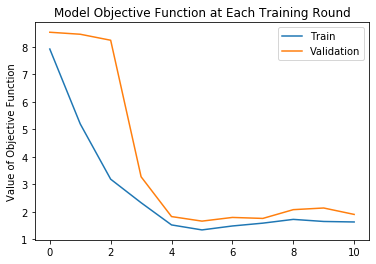

In [71]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Validation')
ax.legend(loc='best')
plt.ylabel('Value of Objective Function')
plt.title('Model Objective Function at Each Training Round')
plt.show()

### Plot Model Accuracy

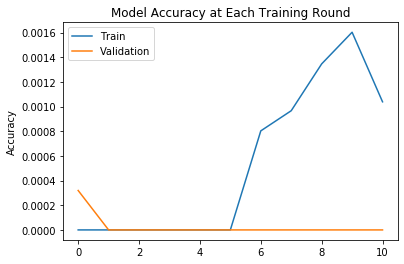

In [72]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Validation')
ax.legend(loc='best')
plt.ylabel('Accuracy')
plt.title('Model Accuracy at Each Training Round')
plt.show()

### Get Final Evaluation

In [73]:
keras_evaluate(server_state, val_data)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


2/2 [==============================] - 6s 3s/step - loss: 1.9860 - num_tokens: 3171.0000 - num_tokens_no_oov: 2999.0000 - num_batches: 2.0000 - num_examples: 200.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00


### Generate Text

In [75]:
keras_model = build_model()
# evaluation_metrics = get_metrics()
# compile_model(keras_model, evaluation_metrics)

tff.learning.assign_weights_to_keras_model(keras_model, server_state.model)
print(generate_text(keras_model, "How are you today"))

how are you today03 toolbar codebase codes shut rules jars completeness acts tests succeeded drawing meaningful consumption embed incoming dynamically utilities 29 browse stats addressed jquery chars prefix metrics glad otherwise composition google terrible uncheck correct faq versa shrink bottleneck else afterwards vertically may subscription edition utf-8 render percentage cleaning framework floats taken
